# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Imports

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import sklearn as sk
import os
import pickle

# Specific functions import
from matplotlib.ticker import FormatStrFormatter
from skimage import exposure
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

# Plot in the notebook
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
# Load pickled data
training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# Some global data to be use along the notebook

# Read class names to title the images
df_sign_names = pd.read_csv('signnames.csv')
dict_sign_names = dict(zip(df_sign_names['ClassId'], df_sign_names['SignName']))
sign_classes = np.array(df_sign_names['ClassId'])

---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set:

In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
S_total = pd.Series(np.concatenate((y_train, y_valid, y_test), axis=0), dtype='str')
n_classes = len(S_total.unique())

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


There is no uniform distribution of examples among classes:

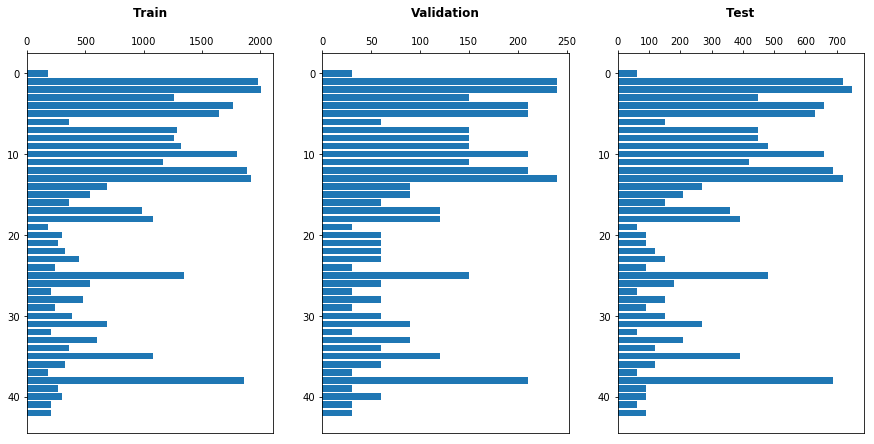

In [5]:
fig = plt.figure(figsize=(15, 7))
subplot_counter = 1
for data, title in zip([y_train, y_valid, y_test],['Train', 'Validation', 'Test']):
    unique, counts = np.unique(data, return_counts=True)
    sbplt = fig.add_subplot(1,3,subplot_counter)
    barplot = plt.barh(unique, counts)
    subplot_counter += 1
    sbplt.invert_yaxis()
    sbplt.xaxis.tick_top()
    sbplt.set_title(title, fontweight = 'bold', fontsize = 12, y = 1.08)
    sbplt.patch.set_visible(False)
    #ax.axes.get_xaxis().set_visible(False)

However, the distribution of examples among classes is similar in training, validation and test sets.

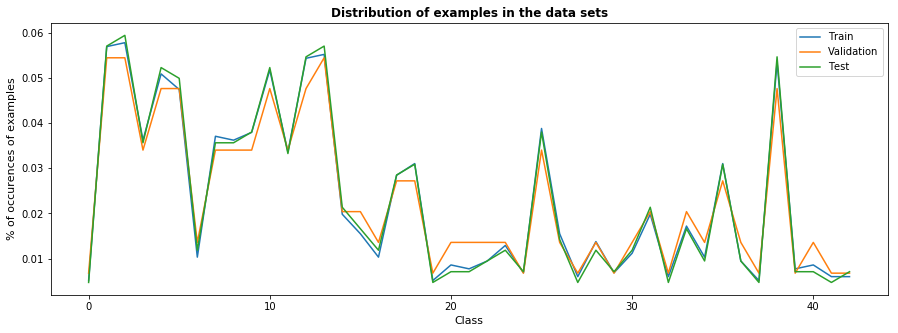

In [6]:
fig = plt.figure(figsize=(15, 5))
for data, title in zip([y_train, y_valid, y_test],['Train', 'Validation', 'Test']):
    unique, counts = np.unique(data, return_counts=True)
    plt.plot(unique, counts/len(data))
plt.xlabel('Class', fontsize = 11)
plt.ylabel('% of occurences of examples', fontsize = 11)
plt.title('Distribution of examples in the data sets', fontweight = 'bold', fontsize = 12)
fig = plt.legend(['Train', 'Validation', 'Test'])

### Exploratory visualization of the dataset

In [7]:
# Helper functions to sample and print images

# Print set of images in n_columns
def print_images(data, labels, num_rows, num_cols, gray = False, figsize=(20, 45)):
    sample_size = num_rows * num_cols
    subplot_counter = 1
    fig = plt.figure(figsize=figsize)
    for image, label in zip(data, labels):
        img_el = fig.add_subplot(sample_size,num_cols,subplot_counter)
        subplot_counter += 1
        if gray:
            imgplot = plt.imshow(image.squeeze(), cmap='gray_r')
        else:
            imgplot = plt.imshow(image)
        img_el.axis('off')
        img_el.set_title(str(label)+' : '+dict_sign_names[label], fontsize=10)

def print_stripes(data, labels, sample_size, sign_classes,
                  print_conv = False, conv_data = None,
                  img_type = 'Sample-original', save_fig = False,  save_dir = 'writeup-images'):

    for sign_class in sign_classes[:]:
        # Count number
        sign_counter = np.sum(labels == sign_class)

        # Get n random images
        img_idx = np.random.choice(np.argwhere( labels == sign_class).flatten(), sample_size).astype('int')
        img_sample = data[img_idx]
        if print_conv:
            conv_img_sample = conv_data[img_idx]

        # Class title
        title = "Class {:2}: {:60} {:>d} images".format(sign_class, dict_sign_names[sign_class], sign_counter)

        # Print images
        fig = plt.figure(figsize = (9,2))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
        for idx in range(sample_size):
            imgplt = fig.add_subplot(2, sample_size, idx+1)
            imgplt.imshow(img_sample[idx])
            imgplt.axis('off')
            if idx == 0:
                imgplt.set_title(title, fontsize = 12, y = 1.08, loc='left', fontname = 'monospace')
            if print_conv:
                imgplt = fig.add_subplot(2, sample_size, sample_size+idx+1)
                imgplt.imshow(conv_img_sample[idx].squeeze(), cmap='gray_r')
                imgplt.axis('off')
            
        if save_fig:
            plt.savefig('{}/{}-{}'.format(save_dir, img_type, sign_class))     
        
# Funcion to sample n training examples from each class
def get_sample_fix_class(data, labels, sign_classes, num_ex_per_class):
    # Select images num_ex_per_class per class
    sample_idx = np.array([], dtype = 'int')
    for sign_class in sign_classes:
        idx = np.random.choice(np.argwhere( labels == sign_class).flatten(), num_ex_per_class).astype('int')
        sample_idx = np.concatenate((sample_idx, idx),axis=0)
    return data[sample_idx], labels[sample_idx]

# Funciont to sample n training examples in same class distribution as original data sets
def get_sample_keep_dist(data, labels, sign_classes, num_total_ex):
    
    unique, counts = np.unique(labels, return_counts=True)
    reduced_distrib = np.maximum(1.0, counts * num_total_ex / len(data)).astype('int')
    class_examples = dict(zip(unique, reduced_distrib))
    
    sample_idx = np.array([], dtype = 'int')
    for sign_class in sign_classes:
        idx = np.random.choice(np.argwhere( labels == sign_class).flatten(), class_examples[sign_class]).astype('int')
        sample_idx = np.concatenate((sample_idx, idx),axis=0)
        
    return data[sample_idx], labels[sample_idx]

Print a stripe of 10 images of each class

//anaconda/envs/sdc/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


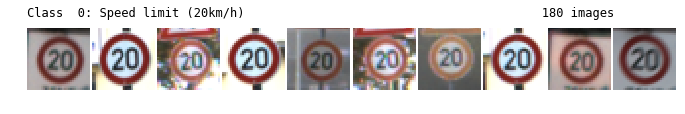

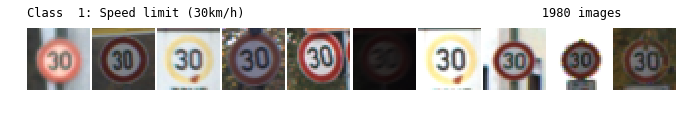

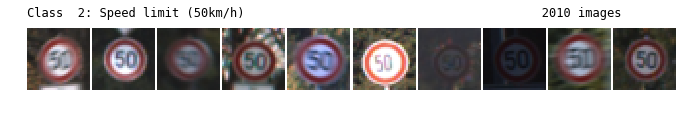

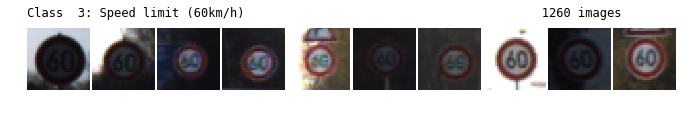

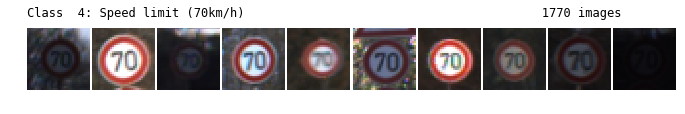

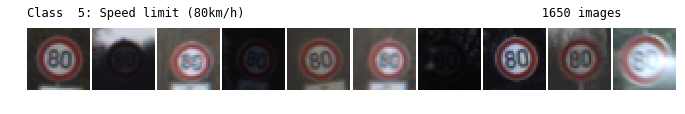

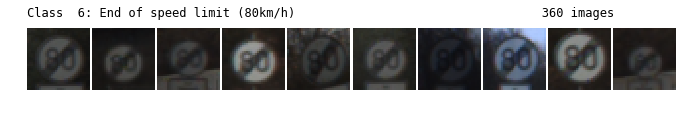

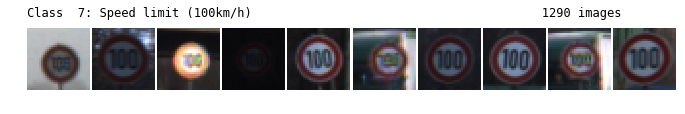

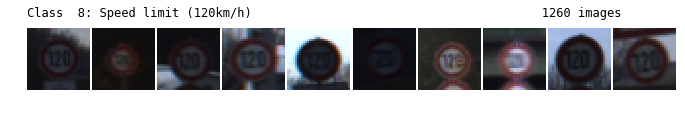

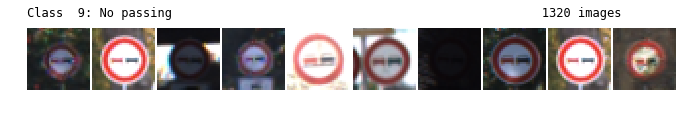

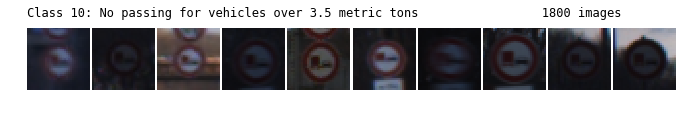

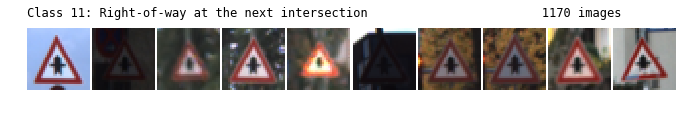

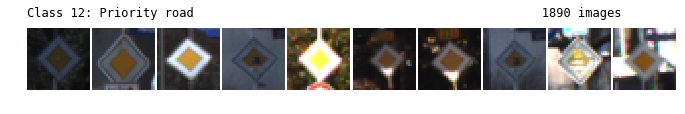

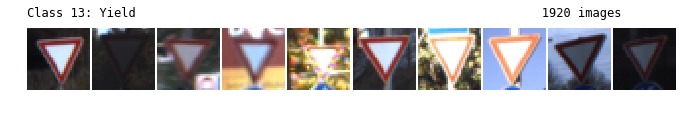

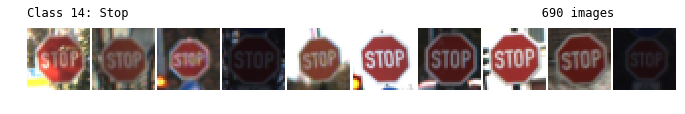

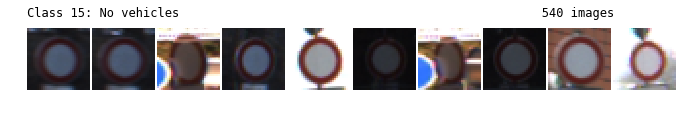

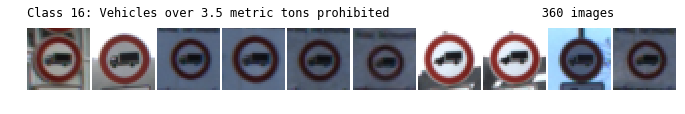

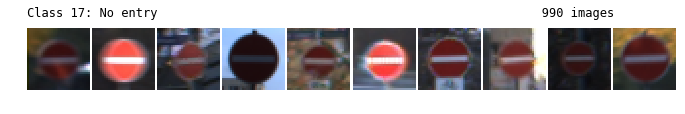

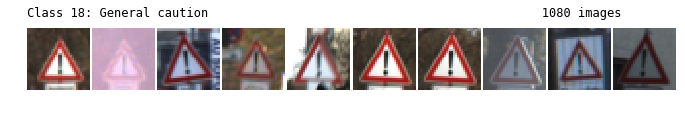

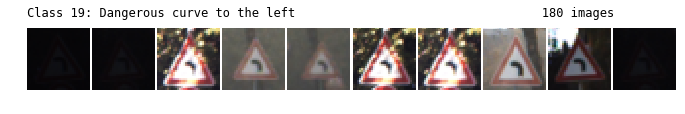

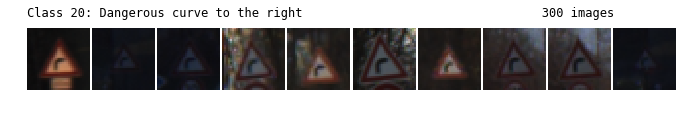

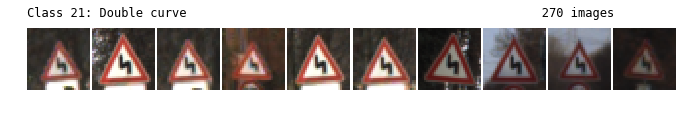

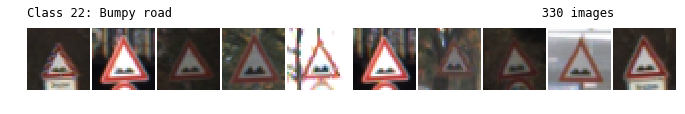

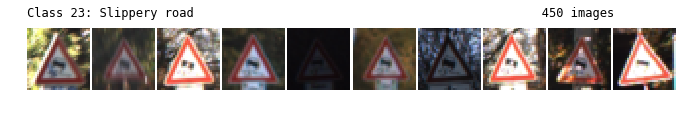

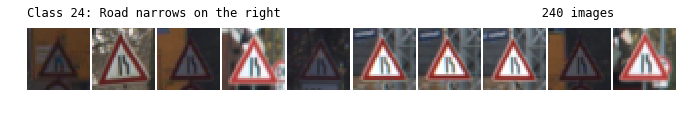

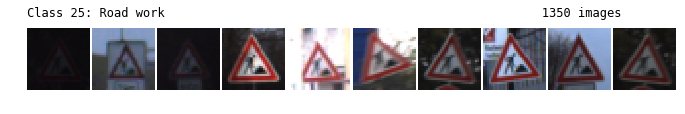

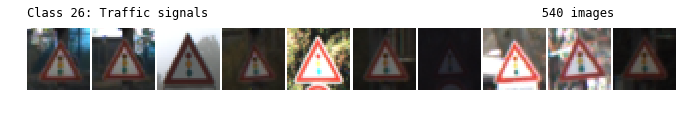

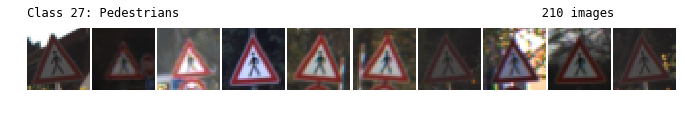

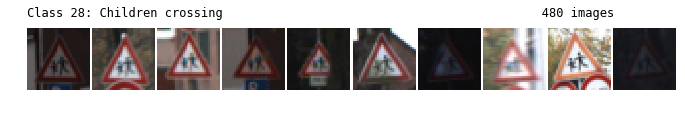

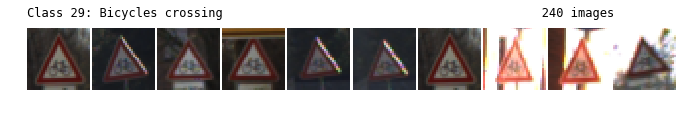

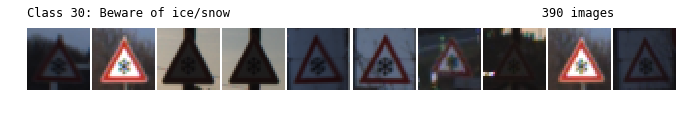

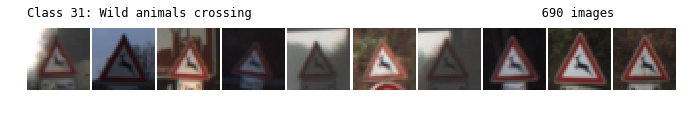

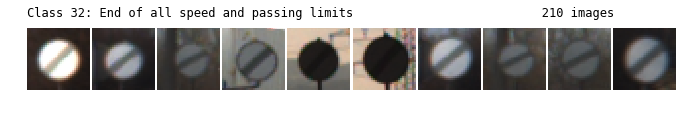

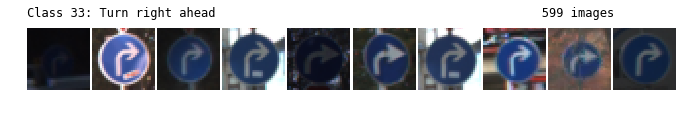

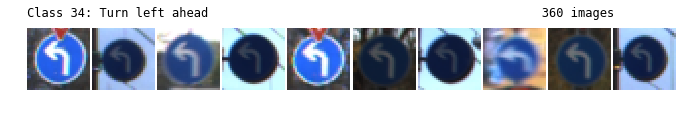

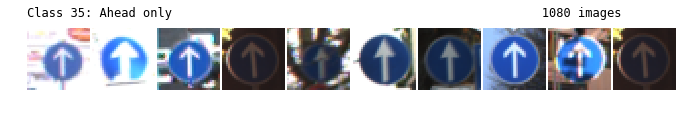

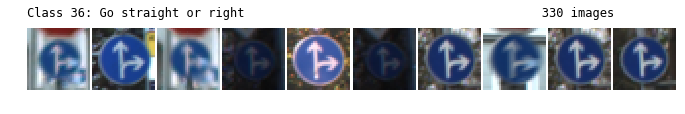

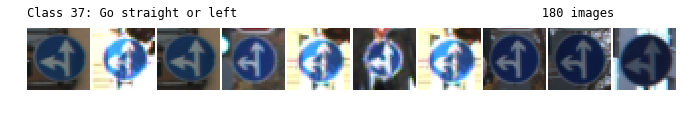

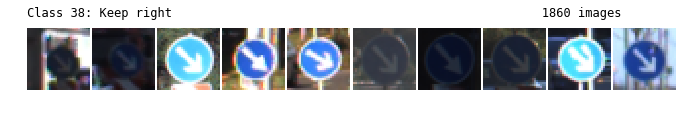

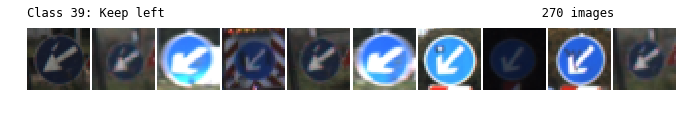

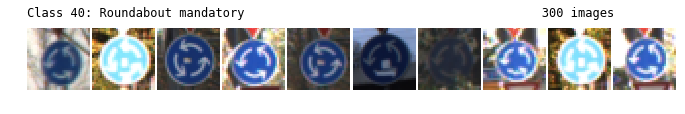

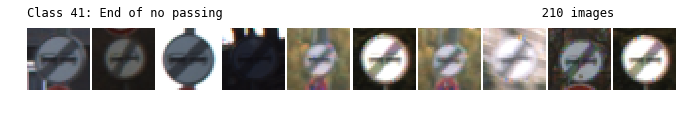

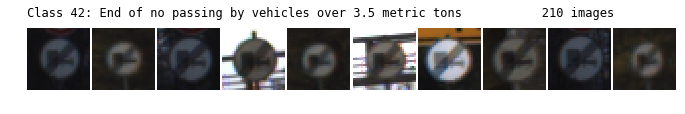

In [8]:
# Set seet for stable results
np.random.seed(2)

# x_sample, y_sample = get_sample_fix_class(X_train, y_train, sign_classes, 1)
# print_images(x_sample, y_sample, 3, 5)
print_stripes(X_train, y_train, 10, sign_classes, save_fig = True)

----

## Step 2: Design and Test Model Architecture

The model architecture will be based in LeNet model adding dropout regularization and and some mage pre-processing.

### Pre-process the Data Set (normalization, grayscale, etc.)

Preprocess data applying 3 techniques:
- Intensity adjustment
- Convert to grayscale
- Normalize the images (using image / 255)

In [9]:
# Pre-processing function
def pre_process_data(data):
    conv_data = 0.299*data[:, :, :, 0] + 0.587*data[:, :, :, 1] + 0.114*data[:, :, :, 2]
    conv_data = conv_data/ 255.
    conv_data = np.array([exposure.equalize_adapthist(image) for image in conv_data])
    return np.expand_dims(conv_data, axis=3)

In [10]:
# Preprocess operation takes long time, so first time we'll convert and save it and then just load from file:
conv_training_file = "traffic-signs-data/conv_train.p"
conv_valid_file = "traffic-signs-data/conv_valid.p"
conv_test_file = "traffic-signs-data/conv_test.p"

# Upload or convert training data
try:
    with open(conv_training_file, mode='rb') as f:
        X_conv_train = pickle.load(f)
    print("Upload converted training data")
except OSError as err:
    print("Converting training data")
    X_conv_train = pre_process_data(X_train)
    pickle.dump( X_conv_train, open( conv_training_file, "wb" ) )

# Upload or convert validation data
try:
    with open(conv_valid_file, mode='rb') as f:
        X_conv_valid = pickle.load(f)
    print("Upload converted validation data")
except OSError as err:
    print("Converting validation data")
    X_conv_valid = pre_process_data(X_valid)
    pickle.dump( X_conv_valid, open( conv_valid_file, "wb" ) )
    
# Upload or convert test data
try:
    with open(conv_test_file, mode='rb') as f:
        X_conv_test = pickle.load(f)
    print("Upload converted test data")
except OSError as err:
    X_conv_test = pre_process_data(X_test)
    print("Converting test data")
    pickle.dump( X_conv_test, open( conv_test_file, "wb" ) )

Upload converted training data
Upload converted validation data
Upload converted test data


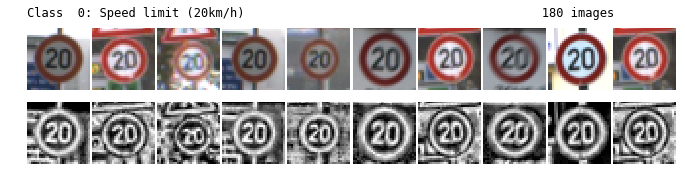

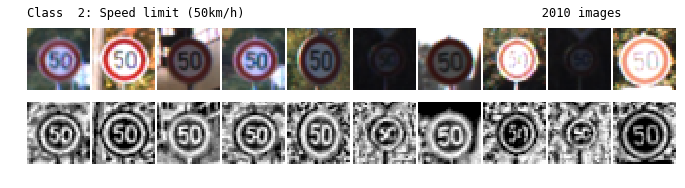

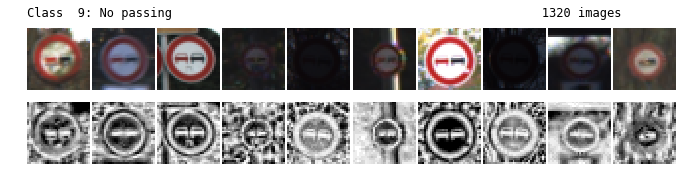

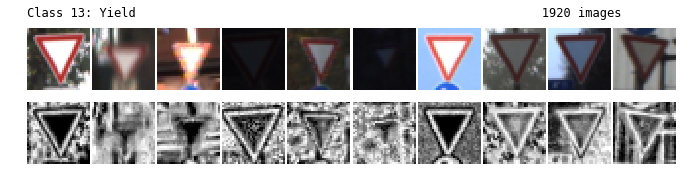

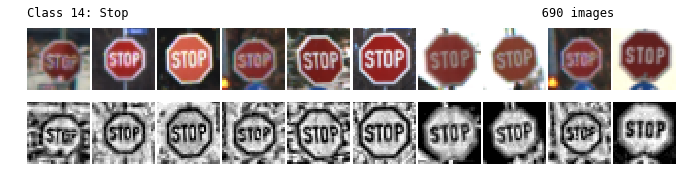

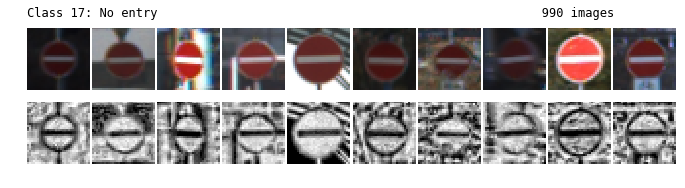

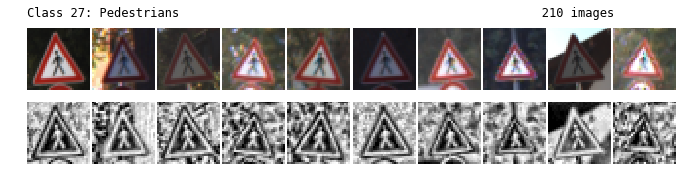

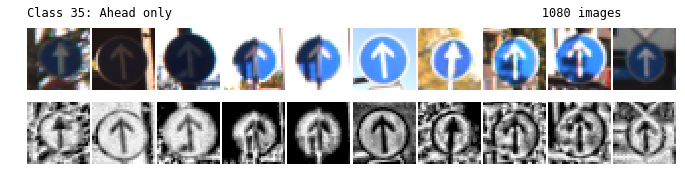

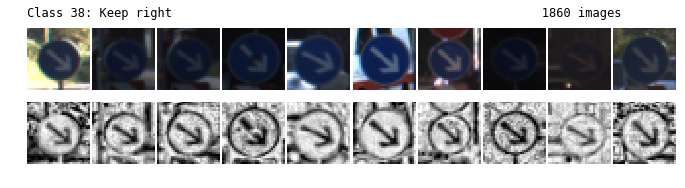

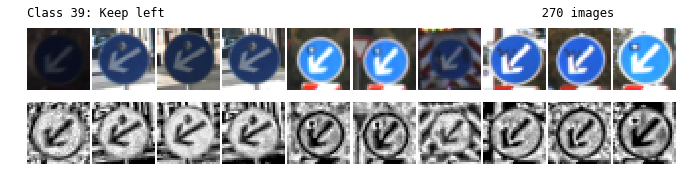

In [11]:
# Test preprocessing
# x_sample, y_sample = get_sample_fix_class(X_conv_train, y_train, sign_classes, 1)
# print_images(x_sample, y_sample, 3, 5, gray = True)
np.random.seed(2)
print_stripes(X_train, y_train, 10, sorted(np.random.choice(sign_classes,10, replace=False)),
              print_conv = True, conv_data = X_conv_train,
              img_type = 'Sample-converted', save_fig = True,  save_dir = 'writeup-images')

### Model Architecture

In [12]:
# Wrappers to simplify CNN definition
def conv2d(x, W, b, stride = 1, padding = 'VALID'):
    temp = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    return tf.nn.bias_add(temp, b)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

In [13]:
# CNN model
def ConvNet(x, weights, biases, keep_prob):   

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)

    # Apply dropout
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(fc0, weights['wf1']), biases['bf1']) 
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Apply dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)    
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wf2']), biases['bf2']) 
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.  
    logits = tf.add(tf.matmul(fc2, weights['wf_out']), biases['bf_out'])
    
    return logits, conv1, conv2, fc1, fc2

In [14]:
# Dicts for layers weight & bias
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# Weights
weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape = (5, 5, 1, 6), mean = mu, stddev = sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma)),
    'wf1': tf.Variable(tf.truncated_normal(shape = (400, 120), mean = mu, stddev = sigma)),
    'wf2': tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma)),
    'wf_out': tf.Variable(tf.truncated_normal(shape = (84, 43), mean = mu, stddev = sigma))    
}

# Biases
biases = {
    'bc1': tf.Variable(tf.zeros(6)),
    'bc2': tf.Variable(tf.zeros(16)),
    'bf1': tf.Variable(tf.zeros(120)),
    'bf2': tf.Variable(tf.zeros(84)),
    'bf_out': tf.Variable(tf.zeros(43))
}

In [15]:
# Graph input & training variables
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)
beta = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)

In [16]:
# Construct model
logits, conv1, conv2, fc1, fc2 = ConvNet(x, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

In [17]:
# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
# Loss function with L2 Regularization with beta=0.01
regularizers = tf.nn.l2_loss(weights['wf1']) + tf.nn.l2_loss(weights['wf2']) + tf.nn.l2_loss(weights['wf_out'])
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation + beta * regularizers)

In [18]:
# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
# Reduce data sets for simple trainings
n_mini_train = 4000 #n_train
n_mini_valid = 1000 #n_validation
n_mini_test = 1000 #n_test

# Get the reduced data keeping class distribution of original data set
X_mini_train, y_mini_train = get_sample_keep_dist(X_conv_train, y_train, sign_classes, n_mini_train)
X_mini_valid, y_mini_valid = get_sample_keep_dist(X_conv_valid, y_valid, sign_classes, n_mini_valid)
X_mini_test, y_mini_test = get_sample_keep_dist(X_conv_test, y_test, sign_classes, n_mini_test)

In [24]:
# Training parameters
epochs = 20
batch_size = 128
exp_lrate_decay = 0.88
base_learning_rate = 0.005
dropout = 0.65 # Dropout, probability to keep units
beta_reg = 0.0
print_interval = 10

In [21]:
epoch_no = []
loss_data = []
acc_data = []
batch_counter = 0

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_mini_train)
    
    print("Training...")
    print()
    for i in range(epochs):
        X_mini_train, y_mini_train = shuffle(X_mini_train, y_mini_train)
        for offset in range(0, num_examples, batch_size):
            l_rate = base_learning_rate * exp_lrate_decay**i
            end = offset + batch_size
            batch_x, batch_y = X_mini_train[offset:end], y_mini_train[offset:end]
            sess.run(training_operation,
                     feed_dict={x: batch_x, y: batch_y, rate:l_rate, keep_prob: dropout, beta: beta_reg})
            
            if batch_counter%print_interval == 0:
                tr_loss, tr_acc = sess.run([loss_operation, accuracy_operation],
                                           feed_dict={x: X_mini_train, y: y_mini_train, keep_prob: 1.0})    
                vl_loss, vl_acc = sess.run([loss_operation, accuracy_operation],
                                           feed_dict={x: X_mini_valid, y: y_mini_valid, keep_prob: 1.0})    
                loss_data.append((tr_loss, vl_loss))
                acc_data.append((tr_acc, vl_acc))
                epoch_no.append(batch_counter)
            batch_counter += 1
        
        print("EPOCH {} ...".format(i+1))
        print("Training Loss\t= {:.4f}\tTraining Accuracy\t= {:.4f}".format(tr_loss, tr_acc))
        print("Validation Loss\t= {:.4f}\tValidation Accuracy\t= {:.4f}".format(vl_loss, vl_acc))
        print()
        if tr_acc > 0.999:
            break

    saver.save(sess, './saved-model/german_traffic_signs')
    print("Model saved")

Training...

EPOCH 1 ...
Training Loss	= 2.9371	Training Accuracy	= 0.2879
Validation Loss	= 3.0476	Validation Accuracy	= 0.2556

EPOCH 2 ...
Training Loss	= 1.7383	Training Accuracy	= 0.5128
Validation Loss	= 1.8440	Validation Accuracy	= 0.4622

EPOCH 3 ...
Training Loss	= 1.1921	Training Accuracy	= 0.6156
Validation Loss	= 1.3105	Validation Accuracy	= 0.5910

EPOCH 4 ...
Training Loss	= 0.8715	Training Accuracy	= 0.7440
Validation Loss	= 0.9830	Validation Accuracy	= 0.6881

EPOCH 5 ...
Training Loss	= 0.7210	Training Accuracy	= 0.8098
Validation Loss	= 0.8525	Validation Accuracy	= 0.7546

EPOCH 6 ...
Training Loss	= 0.5010	Training Accuracy	= 0.8583
Validation Loss	= 0.6164	Validation Accuracy	= 0.8067

EPOCH 7 ...
Training Loss	= 0.4664	Training Accuracy	= 0.8668
Validation Loss	= 0.5983	Validation Accuracy	= 0.7996

EPOCH 8 ...
Training Loss	= 0.4108	Training Accuracy	= 0.8955
Validation Loss	= 0.5396	Validation Accuracy	= 0.8333

EPOCH 9 ...
Training Loss	= 0.4196	Training Accurac

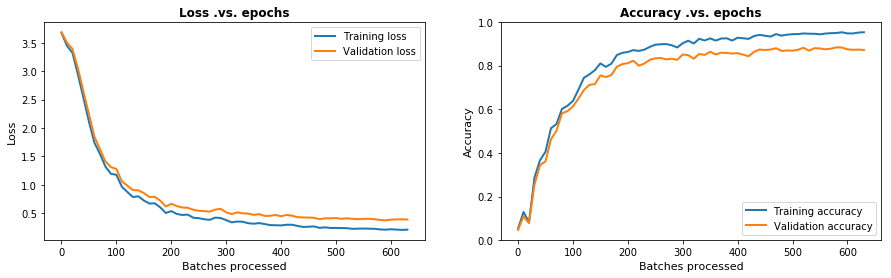

In [25]:
## Print some graphs, test to feed  graph after each epoch
fig = plt.figure(figsize=(15, 4))

# Loss plot
loss_plt = fig.add_subplot(1,2,1)
line1, = loss_plt.plot(epoch_no, [loss[0] for loss in loss_data], linewidth=2, label='Training loss')
line2, = loss_plt.plot(epoch_no, [loss[1] for loss in loss_data], linewidth=2, label='Validation loss')
loss_plt.legend(loc='upper right')
loss_plt.set_title("Loss .vs. epochs", fontweight = 'bold', fontsize = 12)
loss_plt.xaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.xlabel('Batches processed', fontsize = 11)
plt.ylabel('Loss', fontsize = 11)

# Accuracy plot
loss_plt = fig.add_subplot(1,2,2)
line1, = loss_plt.plot(epoch_no, [acc[0] for acc in acc_data], linewidth=2, label='Training accuracy')
line2, = loss_plt.plot(epoch_no, [acc[1] for acc in acc_data], linewidth=2, label='Validation accuracy')
loss_plt.legend(loc='lower right')
loss_plt.set_title("Accuracy .vs. epochs", fontweight = 'bold', fontsize = 12)
loss_plt.xaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.xlabel('Batches processed', fontsize = 11)
plt.ylabel('Accuracy', fontsize = 11)

In [26]:
# Validation accuracy
with tf.Session() as sess:   
    saver.restore(sess, './saved-model/german_traffic_signs') #'./german_traffic_signs')
    test_acc = sess.run(accuracy_operation, feed_dict={x: X_mini_valid, y: y_mini_valid, keep_prob: 1.0})  
print(test_acc)

INFO:tensorflow:Restoring parameters from ./saved-model/german_traffic_signs
0.880368


---

## Step 3: Test a Model on New Images

### Load and Output the Images

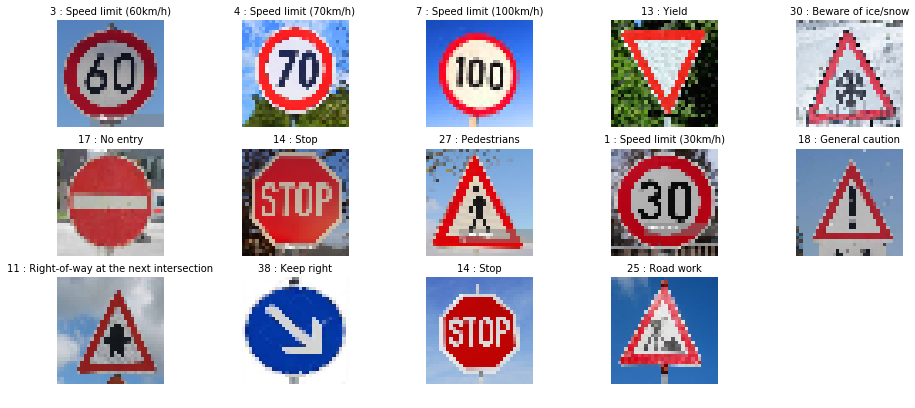

In [31]:
### Load new test images and plot them here.
X_new_test = []
y_new_test = np.array([3, 4, 7, 13, 30, 17, 14, 27, 1, 18, 11, 38, 14, 25]) # Label for each image
for file in os.listdir("new-examples"):
    if file[0] == '.': continue # avoid syste files
    image = cv2.imread(os.path.join("new-examples", file))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    new_image = cv2.resize(image, (32,32))
    X_new_test.append(new_image)
X_new_test = np.array(X_new_test)
print_images(X_new_test, y_new_test, 3, 5, figsize=(16,35))
plt.savefig('writeup-images/new_images')

### Pre-process images

//anaconda/envs/sdc/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


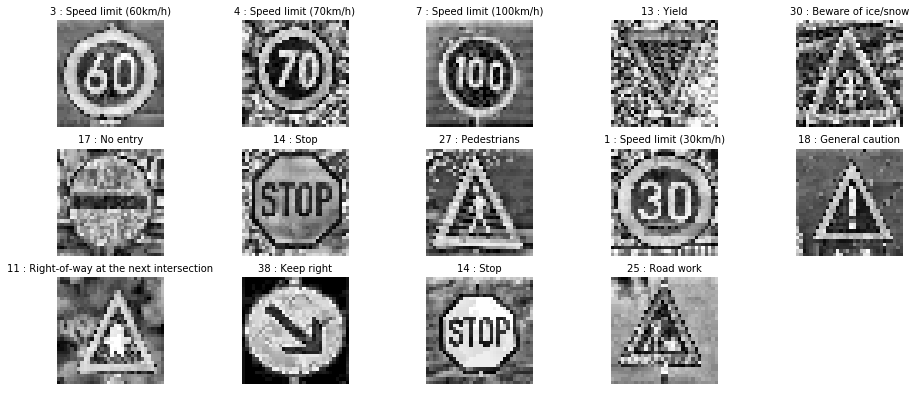

In [32]:
# Print again after preprocessing
X_new_gray = pre_process_data(X_new_test)
print_images(X_new_gray, y_new_test, 3, 5, gray = True, figsize=(16,35))
plt.savefig('writeup-images/new_conv_images')

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./saved-model/german_traffic_signs


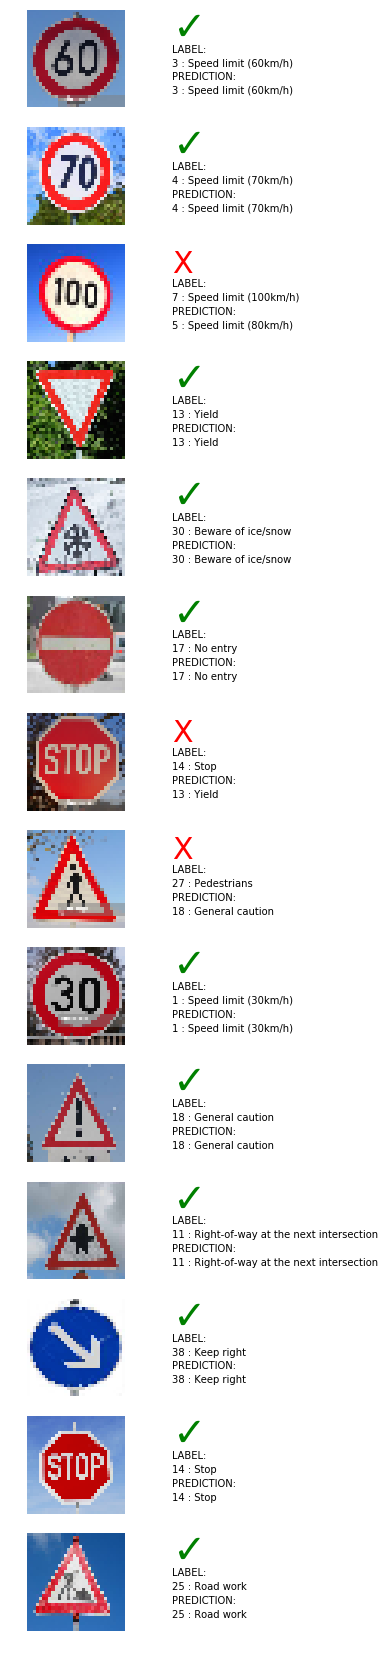

In [33]:
# Run session to get predictions
with tf.Session() as sess:
    saver.restore(sess, './saved-model/german_traffic_signs') #'./german_traffic_signs')
    pred_signs = sess.run(tf.argmax(logits, 1) , feed_dict={x: X_new_gray, y: y_new_test, keep_prob: 1.0})
    new_img_acc = sess.run(accuracy_operation , feed_dict={x: X_new_gray, y: y_new_test, keep_prob: 1.0})    

# Print images + predictions
subplot_counter = 1
fig = plt.figure(figsize=(4, 60))
for image, label, pred_sign in zip(X_new_test, y_new_test, pred_signs):
    img_el = fig.add_subplot(28,2,subplot_counter)
    subplot_counter += 1
    imgplot = plt.imshow(image)
    img_el.axis('off')
    #img_el.set_title(str(label)+' : '+dict_sign_names[label]+
    #                '\t'+str(pred_sign)+' : '+dict_sign_names[pred_sign])
    img_el.set_title("")
    
    text_el = fig.add_subplot(28,2,subplot_counter)
    if label == pred_sign:
        textplot = plt.text(0, 4, r'$\checkmark$', fontsize=40, color='green')
    else:
        textplot = plt.text(0, 4, 'X', fontsize=30, color='red')
    textplot = plt.text(0, 3, "LABEL:")
    textplot = plt.text(0, 2, str(label)+' : '+dict_sign_names[label])
    textplot = plt.text(0, 1, "PREDICTION:")
    textplot = plt.text(0, 0, str(pred_sign)+' : '+dict_sign_names[pred_sign])
    plt.ylim(-1, 6)
    plt.xlim(-0.2, 0.6)
    plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
    subplot_counter += 1
plt.savefig('writeup-images/new_images_predictions')

# Print images + class and prediction
def print_images(data, labels, num_rows, num_cols, gray = False):
    sample_size = num_rows * num_cols

### Analyze Performance

In [34]:
print("New images prediction accuracy = {:.3f}".format(new_img_acc))

New images prediction accuracy = 0.786


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./saved-model/german_traffic_signs


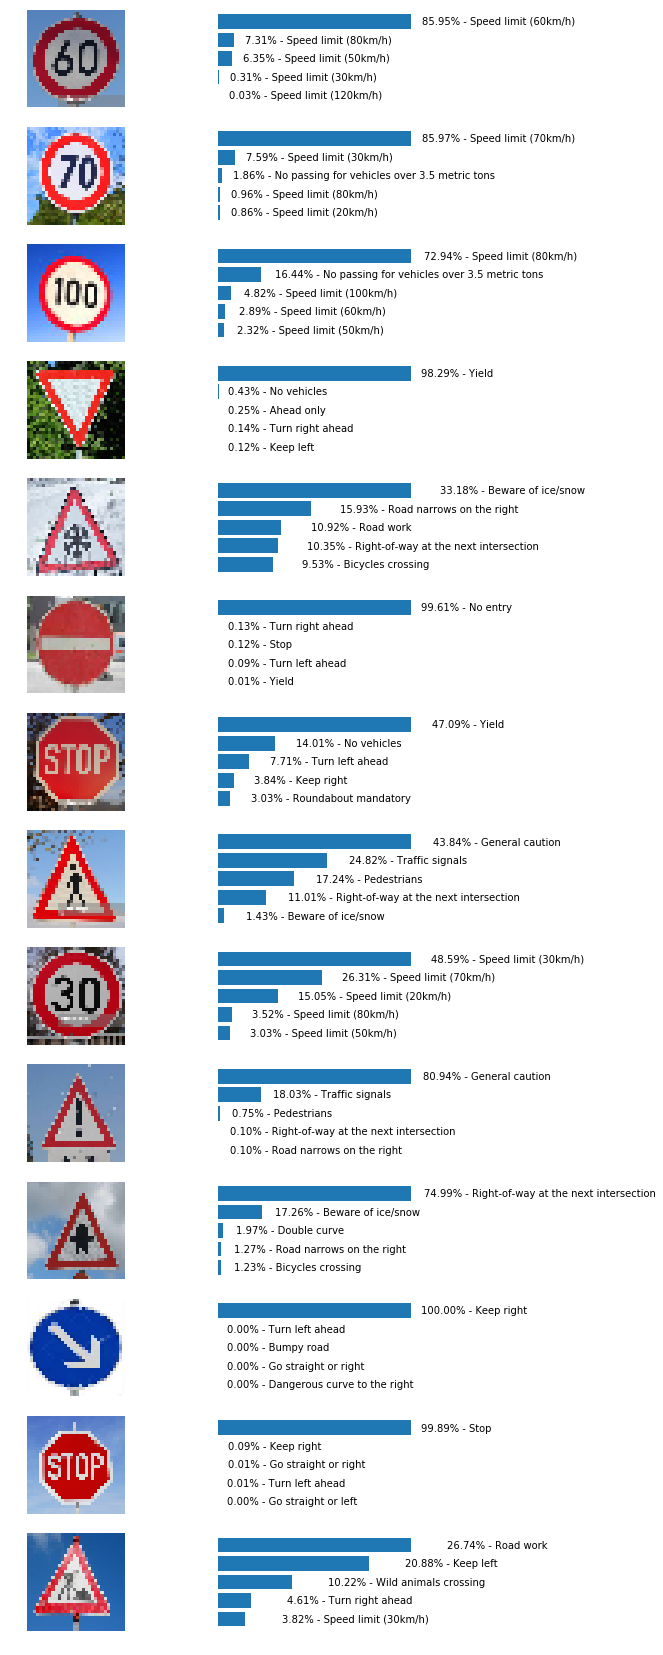

In [37]:
# Run session to get predictions
with tf.Session() as sess:
    saver.restore(sess, './saved-model/german_traffic_signs') #'./german_traffic_signs')
    preds = sess.run(prediction, feed_dict={x: X_new_gray, keep_prob: 1})
    top_pred = sess.run(tf.nn.top_k(preds, k=5))

# Print images with predictions
subplot_counter = 1
fig = plt.figure(figsize=(8, 60))
for image, predictions, idx in zip(X_new_test, top_pred.values, top_pred.indices):
    img_el = fig.add_subplot(28,2,subplot_counter)
    subplot_counter += 1
    img_plot = plt.imshow(image)
    img_el.axis('off')

    bar_el = fig.add_subplot(28,2,subplot_counter)
    subplot_counter += 1
    barplot = plt.barh(range(5), predictions)
    #bar_el.set_title(title)
    bar_el.patch.set_visible(False)
    bar_el.invert_yaxis()
    bar_el.axis('off')
    bar_el.set_yticklabels(idx)
    for i, v in enumerate(zip(predictions, idx)):
        value, index = v
        bar_el.text(value+0.05, i+.15, '{:.2f}% - {}'.format(value*100, dict_sign_names[index]))
        
#Class {:2}: {:60} {:>d} images
plt.savefig('writeup-images/new_images_top_predictions')

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [38]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './saved-model/german_traffic_signs')
    print("convolution #1")
    outputFeatureMap(X_new_gray[12:], conv1)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './saved-model/german_traffic_signs')
    print("convolution #2")
    outputFeatureMap(X_new_gray[12:], conv2)